# Importing libraries

In [1]:
import os
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from sklearn.metrics import recall_score

from utils.inference import *
from utils.metrics import *

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

# Specifying trained model

In [2]:
EXP_NAME = 'c3adc367-329a-4189-8fd0-69d97ec26f1f'

with open(f'experiments/{EXP_NAME}/config.json') as json_file:
    config = json.load(json_file)

config = edict(config)

# Evaluation

In [3]:
df = pd.DataFrame(columns=['dice', 'iou', 'contrast', 'recall', 'top_10_crop', 'min_number_crops'])

for subject in tqdm(config.subjects):
    
    with open(f'experiments/{EXP_NAME}/predictions/{subject}.json') as json_file:
        net_output = json.load(json_file)
    
    predictions_inside_brain = np.array(net_output['predictions']) * (1 - np.array(net_output['air_maks']))
    labels_inside_brain = np.array(net_output['labels']) * (1 - np.array(net_output['air_maks']))
    
    contrast = np.round(calculate_contrast(labels_inside_brain, predictions_inside_brain), decimals=2)
    recall = np.round(recall_score(labels_inside_brain, (predictions_inside_brain > 0.5).astype(np.int)), decimals=2)
    top10_score, min_number_crops = top10_f(predictions_inside_brain, labels_inside_brain, np.array(net_output['coordinates']))
    
    binary_predictions = (predictions_inside_brain > 0.5).astype(np.int)
    tp = sum(binary_predictions * labels_inside_brain)
    fp = sum(binary_predictions * (1-labels_inside_brain))
    fn = sum((1-binary_predictions) * labels_inside_brain)
    
    dice = 2*tp/(2*tp+fp+fn)
    iou = tp/(tp+fp+fn)
    
    df.loc[subject] = [dice, iou, contrast, recall, np.round(top10_score, decimals=2), min_number_crops]

df.sort_values(by=['top_10_crop', 'contrast'], ascending=False, inplace=True)
df.loc['mean'] = df.mean()
df = df[['contrast', 'recall', 'top_10_crop', 'min_number_crops', 'dice', 'iou']]
df.to_csv(f'experiments/{EXP_NAME}/pc_metrics.csv')

100%|██████████| 46/46 [00:44<00:00,  1.04it/s]


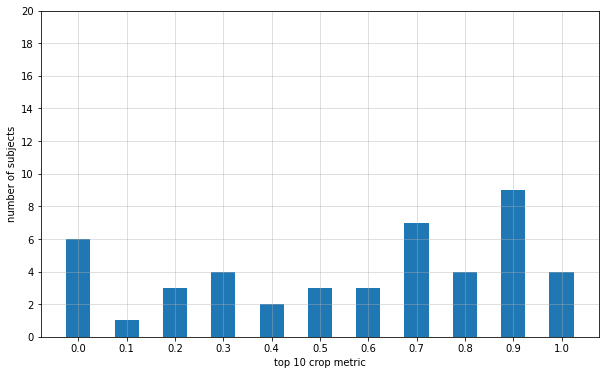

In [4]:
df_metric = pd.DataFrame(df.top_10_crop[:-1].value_counts())

fig, axs =  plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})

plt.bar(df_metric.index.tolist(),
        df_metric.top_10_crop.tolist(),
        width = 0.05,
       tick_label=df_metric.index.tolist())
plt.grid(True, alpha=0.5)
plt.ylim(0, 20)
plt.yticks(range(0, 22, 2))
plt.ylabel('number of subjects')
plt.xlabel('top 10 crop metric')
plt.savefig(f'experiments/{EXP_NAME}/pc_histogram_top_10_score.jpeg')